In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fmin
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

np.random.seed(20090425)

---

# Regression modeling

A general, primary goal of many statistical data analysis tasks is to relate the influence of one variable on another. 

For example: 

- how different medical interventions influence the incidence or duration of disease
- how baseball player's performance varies as a function of age.
- [how test scores are correlated with tissue LSD concentration](http://onlinelibrary.wiley.com/doi/10.1002/cpt196895635/abstract)

In [2]:
from io import StringIO

data_string = """
Drugs	Score
0	1.17	78.93
1	2.97	58.20
2	3.26	67.47
3	4.69	37.47
4	5.83	45.65
5	6.00	32.92
6	6.41	29.97
"""

lsd_and_math = pd.read_table(StringIO(data_string), sep='\t', index_col=0)
lsd_and_math

,Drugs,Score
0,1.17,78.93
1,2.97,58.20
2,3.26,67.47
3,4.69,37.47
4,5.83,45.65
5,6.00,32.92
6,6.41,29.97


![lsd](images/_lsd.jpg)

> Taking LSD was a profound experience, one of the most important things in my life --Steve Jobs

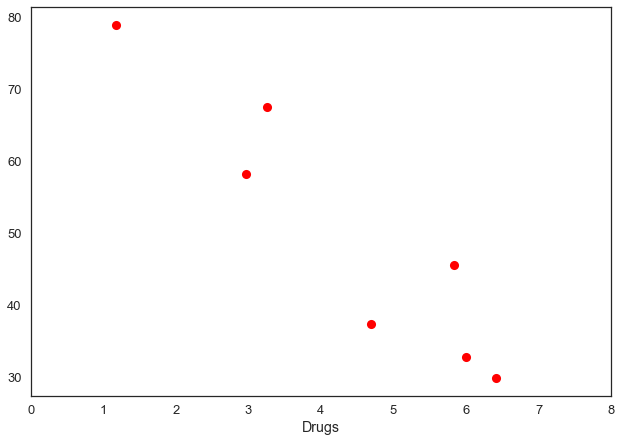

In [3]:
lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8));

We can build a model to characterize the relationship between $X$ and $Y$, recognizing that additional factors other than $X$ (the ones we have measured or are interested in) may influence the response variable $Y$.

- $M(Y|X) = E(Y|X)$
- $M(Y|X) = Pr(Y=1|X)$

In general,

$$M(Y|X) = f(X)$$

for a regression model,

$$M(Y|X) = f(X\beta)$$

where $f$ is some function, for example a linear function:

<div style="font-size: 150%;">  
$y_i = \beta_0 + \beta_1 x_{1i} + \ldots + \beta_k x_{ki} + \epsilon_i$
</div>

Regression is a **weighted sum** of independent predictors

and $\epsilon_i$ accounts for the difference between the observed response $y_i$ and its prediction from the model $\hat{y_i} = \beta_0 + \beta_1 x_i$. This is sometimes referred to as **process uncertainty**.

Interpretation: coefficients represent the change in Y for a unit increment of the predictor X.

Two important linear regression **assumptions**:

1. normal errors
2. homoscedasticity


## Parameter estimation

We would like to select $\beta_0, \beta_1$ so that the difference between the predictions and the observations is zero, but this is not usually possible. Instead, we choose a reasonable criterion: ***the smallest sum of the squared differences between $\hat{y}$ and $y$***.

<div style="font-size: 120%;">  
$$R^2 = \sum_i (y_i - [\beta_0 + \beta_1 x_i])^2 = \sum_i \epsilon_i^2 $$  
</div>

Squaring serves two purposes: 

1. to prevent positive and negative values from cancelling each other out
2. to strongly penalize large deviations. 

Whether or not the latter is a desired depends on the goals of the analysis.

In other words, we will select the parameters that minimize the squared error of the model.

In [4]:
sum_of_squares = lambda θ, x, y: np.sum((y - θ[0] - θ[1]*x) ** 2)

Here is a sample calculation, using aribitrary parameter values:

In [5]:
sum_of_squares([0,1], lsd_and_math.Drugs, lsd_and_math.Score)

17159.815399999999

However, we have the stated objective of minimizing the sum of squares, so we can pass this function to one of several optimizers in SciPy:

In [6]:
x, y = lsd_and_math.T.values
b0, b1 = fmin(sum_of_squares, [0,1], args=(x,y))
b0, b1

Optimization terminated successfully.
         Current function value: 253.881329
         Iterations: 97
         Function evaluations: 179


(89.123909209804239, -9.0094696583309499)

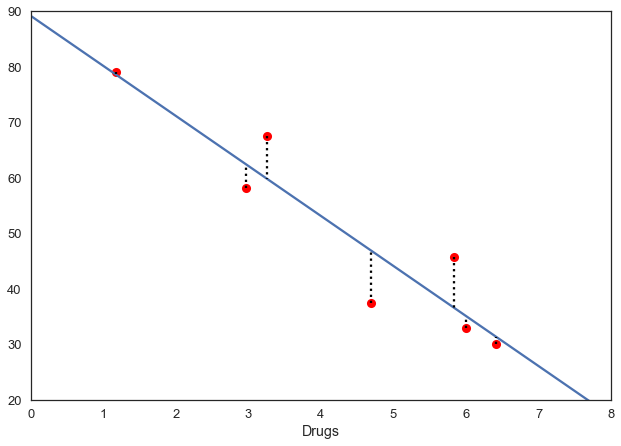

In [7]:
ax = lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8), ylim=(20, 90))
ax.plot([0,10], [b0, b0+b1*10])
for xi, yi in zip(x,y):
    ax.plot([xi]*2, [yi, b0+b1*xi], 'k:')

## Alternative loss functions

Minimizing the sum of squares is not the only criterion we can use; it is just a very popular (and successful) one. For example, we can try to minimize the sum of absolute differences:

In [8]:
sum_of_absval = lambda θ, x, y: np.sum(np.abs(y - θ[0] - θ[1]*x))

Optimization terminated successfully.
         Current function value: 31.692066
         Iterations: 137
         Function evaluations: 264

intercept: 9e+01, slope: -9.3


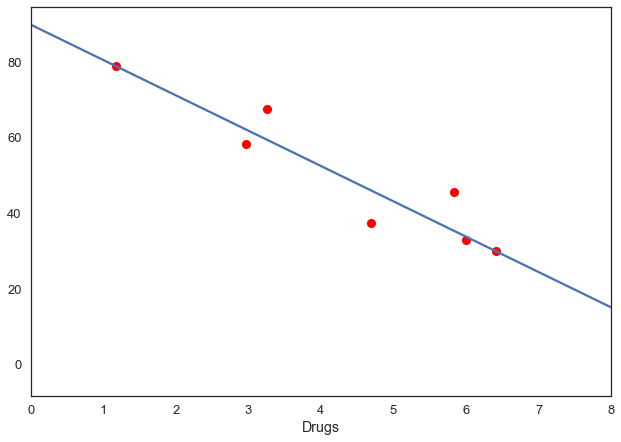

In [9]:
b0, b1 = fmin(sum_of_absval, [0,0], args=(x,y))
print('\nintercept: {0:.2}, slope: {1:.2}'.format(b0,b1))
ax = lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8))
ax.plot([0,10], [b0, b0+b1*10])

### Exercise

1. Append an additional, extreme observation: `{'Drugs': 6, 'Score': 70}`.

2. Re-fit the model using both the sum of squares error and sum of absolute values error, and compare the resulting estimates.

In [10]:
# Write answer here

## Polynomial regession

We are not restricted to a straight-line regression model; we can represent a curved relationship between our variables by introducing **polynomial** terms. For example, a cubic model:

<div style="font-size: 150%;">  
$y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \epsilon_i$
</div>

In [11]:
sum_squares_quad = lambda θ, x, y: np.sum((y - θ[0] - θ[1]*x - θ[2]*(x**2)) ** 2)

Optimization terminated successfully.
         Current function value: 251.093792
         Iterations: 177
         Function evaluations: 319

intercept: 9.2e+01, x: -1.1e+01, x2: 0.24


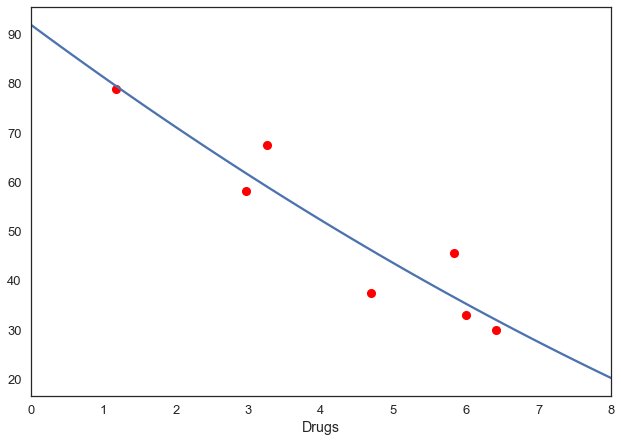

In [12]:
b0,b1,b2 = fmin(sum_squares_quad, [1,1,-1], args=(x,y))
print('\nintercept: {0:.2}, x: {1:.2}, x2: {2:.2}'.format(b0,b1,b2))
ax = lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8))
xvals = np.linspace(0, 8, 100)
ax.plot(xvals, b0 + b1*xvals + b2*(xvals**2))

Although a polynomial model characterizes a nonlinear relationship, it is a linear problem in terms of estimation. That is, the regression model $f(y | x)$ is **linear in the parameters**.

For some data, it may be reasonable to consider polynomials of order>2. For example, consider the relationship between the number of spawning salmon and the number of juveniles recruited into the population the following year; one would expect the relationship to be positive, but not necessarily linear.

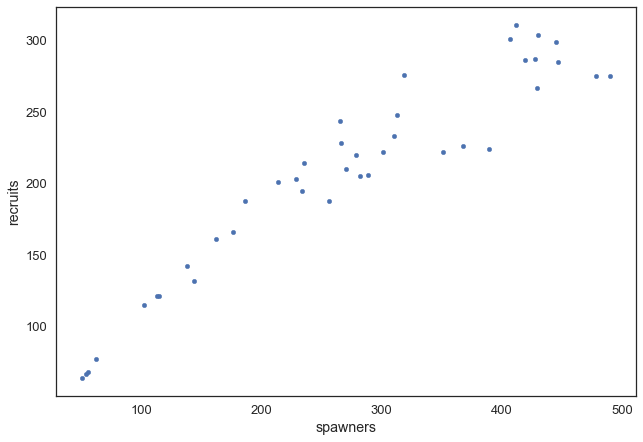

In [13]:
salmon = pd.read_table("../data/salmon.dat", delim_whitespace=True, index_col=0)
salmon.plot.scatter(x='spawners', y='recruits');

### Exercise

Create a sum of squares function for a cubic regression (order=3), and fit this function to the salmon spawning data.

In [14]:
# Write your answer here

## Bayesian Linear Regression with PyMC3

In practice, we need not fit least squares models by hand because they are implemented generally in packages such as [`scikit-learn`](http://scikit-learn.org/) and [`statsmodels`](https://github.com/statsmodels/statsmodels/). Moreover, we are interested not only in obtaining a line of best fit, but also **estimates of uncertainty** in the line and the parameters used to calculate the line.

Here, we will return to a Bayesian approach and build a regression model in PyMC3.

### Priors

The first step in specifying our model is to specify priors for our model. Since regression parameters are continuous, and potentially positive or negative, we can use a Normal distribution with a variance set to an appropriate value that reflects our prior knowledsge of the parameter.

$$\beta_i \sim \text{Normal}(0, 100)$$

The other latent variable is the residual variance of the observations after applying our model. This is the **process uncertainty** that we identified earlier. 

$$\sigma \sim \text{HalfCauchy}(1)$$

The **half-Cauchy** distribution used here provides support over positive continuous values, and has relatively large tail probabilities, allowing for the possibility of extreme values.

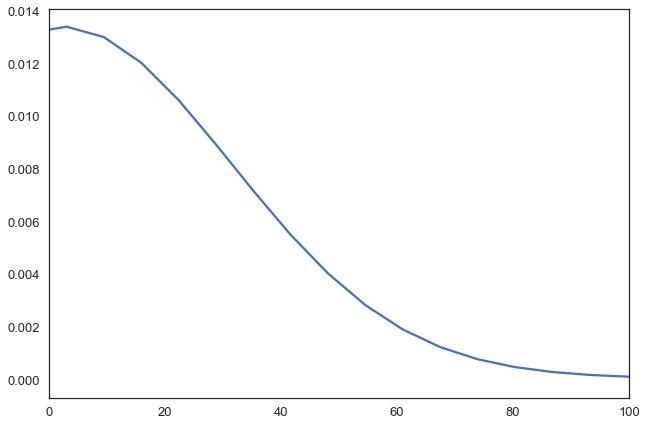

In [15]:
from pymc3 import HalfCauchy

ax = sns.kdeplot(HalfCauchy.dist(1).random(size=10000), gridsize=2000)
ax.set_xlim(0, 100);

In [16]:
from pymc3 import Normal, Model

with Model() as drugs_model:
    
    intercept = Normal('intercept', 0, sd=100)
    slope = Normal('slope', 0, sd=100)
    σ = HalfCauchy('σ', 1)

### Likelihood

The sampling distribution of the data for a regression model is a normal distribution, and we specified the standard deviation for this sampling distribution in $\sigma$ above. 

$$y_i \sim \text{Normal}(\mu_i, \sigma)$$

Here, $\mu_i$ is the expected value of the *i*th observation, which is generated by the regression model at the corresponding value of $x$. We can calculate this expected value as a function of the regression parameters and the data, and pass it to the normal likelihood:

In [17]:
with drugs_model:
    
    μ = intercept + slope*x
    score = Normal('score', μ, sd=σ, observed=y)

That's it!

The regression model is fully specified with these 5 lines of Python code. We can now use the fitting method of our choice to estimate a posterior distribution. In the previous module, we used variational inference, here we will use a **Markov chain Monte Carlo** algorithm, called **NUTS** (the No U-Turn Sampler).

In [18]:
from pymc3 import sample

with drugs_model:

    drugs_sample = sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Average Loss = 40.598:  58%|█████▊    | 116571/200000 [00:09<00:05, 14090.79it/s]
Convergence archived at 118000
Interrupted at 118,000 [59%]: Average Loss = 222.52
 99%|█████████▉| 1482/1500 [00:01<00:00, 900.88it/s]/Users/fonnescj/anaconda3/envs/stat_pycon/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:247: UserWarning: Chain 0 contains diverging samples after tuning. If increasing `target_accept` doesn't help, try to reparameterize.
  "try to reparameterize." % chain)
100%|██████████| 1500/1500 [00:01<00:00, 808.83it/s]


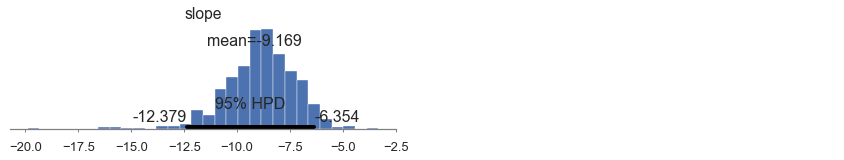

In [19]:
from pymc3 import plot_posterior

plot_posterior(drugs_sample, varnames=['slope']);

Because we have a vector of samples from the estimated posterior, it is easy to calculate means, medians, standard deviations, and probability intervals. Above, we see the mean and the 95% **posterior credible interval** reported.

### Exercise

Fit a quadratic model for the salmon spawning data, using PyMC3.

In [20]:
# Write your answer here

## Checking model fit

One intuitive way of evaluating model fit is to compare model predictions with the observations used to fit the model. In other words, the fitted model can be used to **simulate
data**, and the distribution of the simulated data should resemble the distribution of the actual data.

Fortunately, simulating data from the model is a natural component of the Bayesian modelling framework. Recall, from our introduction to Bayesian inference, the **posterior predictive distribution**:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

Here, $\tilde{y}$ represents some hypothetical new data that would be expected, taking into account the posterior uncertainty in the model parameters. 

Sampling from the posterior predictive distribution is straighforward in PyMC; the `sample_ppc` function draws posterior predictive checks from all of the data likelihoods. 

In [21]:
from pymc3 import sample_ppc

with drugs_model:
    
    drugs_ppc = sample_ppc(drugs_sample, 1000)

100%|██████████| 1000/1000 [00:19<00:00, 51.35it/s]


This yields 1000 samples corresponding to each of the seven data points in our observation vector. 

In [22]:
drugs_ppc['score'].shape

(1000, 7)

We can then compare these simulated data to the data we used to fit the model. Our claim is that the model might have plausibly been used to generate the data that we observed.

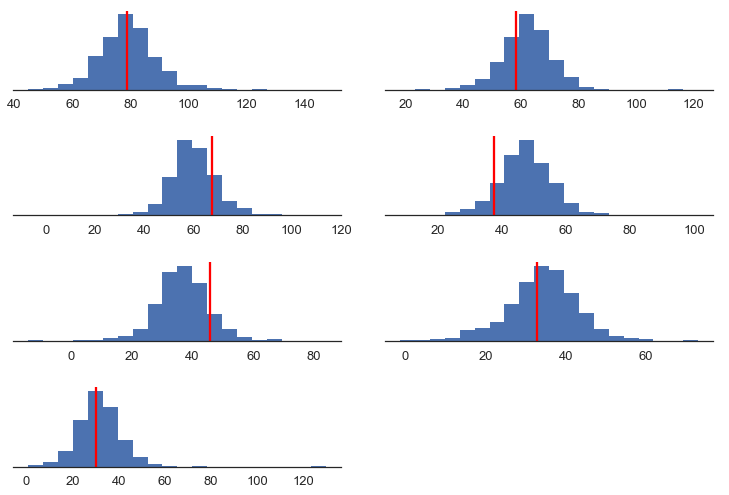

In [23]:
fig, axes = plt.subplots(4, 2)
axes_flat = axes.flatten()

for ax, real_data, sim_data in zip(axes_flat[:-1], y, drugs_ppc['score'].T):
    ax.hist(sim_data, bins=20)
    ax.vlines(real_data, *ax.get_ylim(), colors='red')
    ax.set_yticklabels([])
    sns.despine(left=True)

axes_flat[-1].axis('off')
plt.tight_layout()

## Generalized linear models

Often our data violates one or more of the linear regression assumptions:

- non-linear
- non-normal error distribution
- heteroskedasticity

this forces us to **generalize** the regression model in order to account for these characteristics.

As a motivating example, consider the Olympic medals data that we compiled earlier in the tutorial.

![relay](images/mascot.png)

In [24]:
medals = pd.read_csv('../data/medals.csv')
medals.head()

,medals,population,oecd,log_population
0,1,96165,0,11.473821
1,1,281584,0,12.548186
2,6,2589043,0,14.766799
3,25,10952046,0,16.209037
4,41,18348078,1,16.725035


We expect a positive relationship between population and awarded medals, but the data in their raw form are clearly not amenable to linear regression.

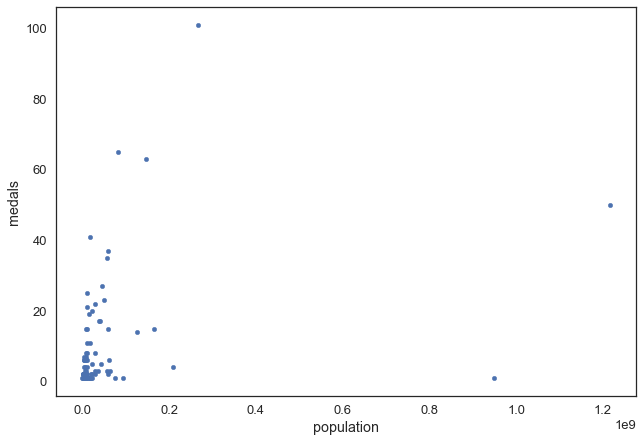

In [25]:
medals.plot(x='population', y='medals', kind='scatter')

Part of the issue is the scale of the variables. For example, countries' populations span several orders of magnitude. We can correct this by using the logarithm of population, which we have already calculated.

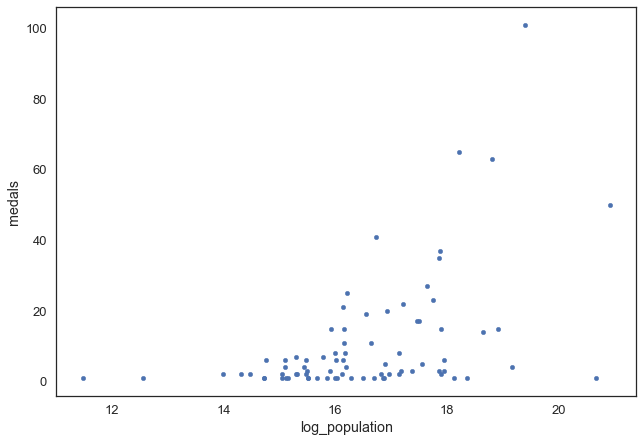

In [26]:
medals.plot(x='log_population', y='medals', kind='scatter')

This is an improvement, but the relationship is still not adequately modeled by least-squares regression.

In [27]:
from pymc3 import fit

x = medals.log_population.values
y = medals.medals.values

with Model() as medals_linear:
    
    intercept = Normal('intercept', 0, sd=100)
    slope = Normal('slope', 0, sd=100)
    σ = HalfCauchy('σ', 1)
    
    μ = intercept + slope*x
    score = Normal('score', μ, sd=σ, observed=y)
    
    samples = sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 345.52:  53%|█████▎    | 106751/200000 [00:09<00:07, 12527.52it/s]
Convergence archived at 107000
Interrupted at 107,000 [53%]: Average Loss = 732.03
100%|██████████| 1000/1000 [00:02<00:00, 418.95it/s]


In [28]:
yhat = samples['intercept'].mean() + samples['slope'].mean() * np.linspace(10, 22)

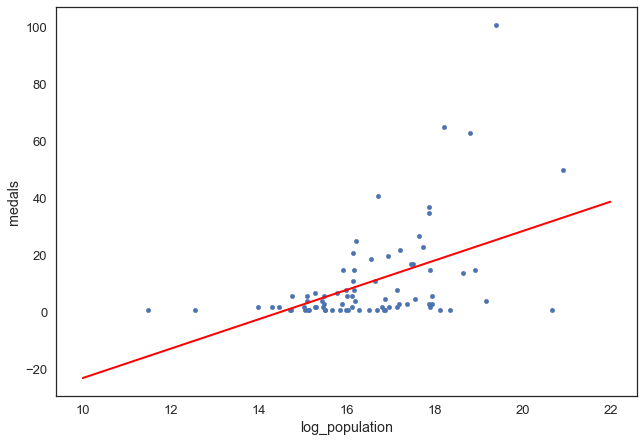

In [29]:
ax = medals.plot(x='log_population', y='medals', kind='scatter')
ax.plot(np.linspace(10, 22), yhat, color='red',
         linewidth=2)

This is due to the fact that the response data are **counts**. As a result, they tend to have characteristic properties. 

- discrete
- positive
- variance grows with mean

to account for this, we can do two things: (1) model the medal count on the **log scale** and (2) assume **Poisson errors**, rather than normal.

Recall the Poisson distribution from the previous section:

$$p(y)=\frac{e^{-\lambda}\lambda^y}{y!}$$

* $Y=\{0,1,2,\ldots\}$
* $\lambda > 0$

$$E(Y) = \text{Var}(Y) = \lambda$$

So, we will model the logarithm of the expected value as a linear function of our predictors:

$$\log(\lambda) = X\beta$$

In this context, the log function is called a **link function**. This transformation implies the mean of the Poisson is:

$$\lambda = \exp(X\beta)$$

We can plug this into the Poisson likelihood and use maximum likelihood to estimate the regression covariates $\beta$.

$$\log L = \sum_{i=1}^n -\exp(X_i\beta) + Y_i (X_i \beta)- \log(Y_i!)$$

As we have already done, we just need to code the kernel of this likelihood, and optimize!

In [30]:
# Poisson negative log-likelhood
poisson_loglike = lambda β, X, y: -(-np.exp(X.dot(β)) + y*X.dot(β)).sum()

Let's use the `assign` method to add a column of ones to the design matrix.

In [31]:
poisson_loglike([0,1], medals[['log_population']].assign(intercept=1), medals.medals)

-627.25573555173571

We will use Nelder-Mead to minimize the negtive log-likelhood.

In [32]:
b1, b0 = fmin(poisson_loglike, [0,1], args=(medals[['log_population']].assign(intercept=1).values, 
                                            medals.medals.values))

Optimization terminated successfully.
         Current function value: -1381.299433
         Iterations: 68
         Function evaluations: 131


In [33]:
b0, b1

(-5.2973029170604393, 0.44873025169011005)

The resulting fit looks reasonable.

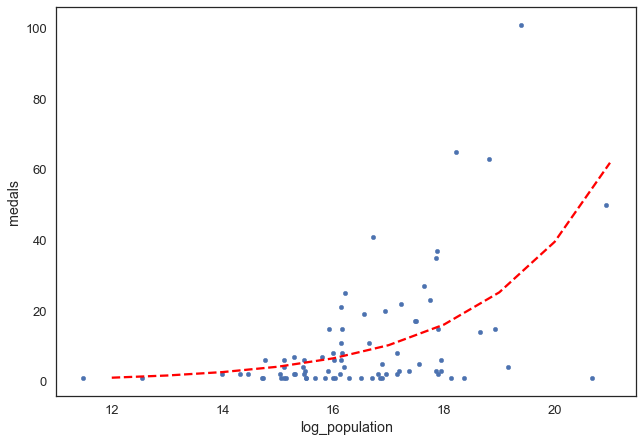

In [34]:
ax = medals.plot(x='log_population', y='medals', kind='scatter')
xvals = np.arange(12, 22)
ax.plot(xvals, np.exp(b0 + b1*xvals), 'r--')

### Exercise: Poisson regression

Code the Poisson regression model above in PyMC3 (*Hint*: you will need to specify a Poisson distribution somewhere!).

In [35]:
# Write your answer here

### Exercise: Multivariate GLM

Add the OECD indicator variable to the model, and estimate the model coefficients.

In [36]:
# Write your answer here

## Logistic Regression

Fitting a line to the relationship between two variables using the least squares approach is sensible when the variable we are trying to predict is continuous, but what about when the data are dichotomous?

- male/female
- pass/fail
- died/survived

Let's revisit the *very low birthweight infants* dataset from the last module.

In [69]:
vlbw = pd.read_csv('../data/vlbw.csv', index_col=0).dropna(axis=0, subset=['ivh', 'pneumo'])
ivh = vlbw.ivh.isin(['definite', 'possible']).astype(int).values
pneumo = vlbw.pneumo.values

Previously, we were comparing the number of **intra-ventricular hemorrhage** events between two groups, those with and without a pneumothorax, where we found a higher probability of IVH associated with pneumothorax. However, its possible that  lower birthweight accounts for the difference, since birthweight is nominally lower in the pneumothorax group:

In [70]:
vlbw.groupby('pneumo').bwt.mean()

pneumo
0.0    1089.395122
1.0    1035.355140
Name: bwt, dtype: float64

Let's consider the relative number of events as a function of birthweight, then.

In [71]:
bwt_kg = vlbw.bwt.values/1000

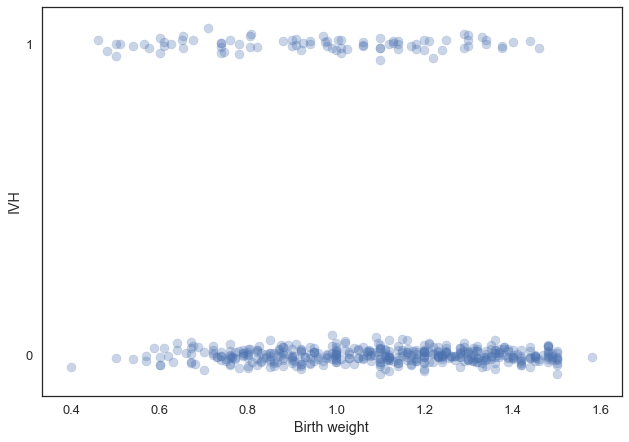

In [72]:
jitter = np.random.normal(scale=0.02, size=len(vlbw))

plt.scatter(bwt_kg, ivh + jitter, alpha=0.3)
plt.yticks([0,1])
plt.ylabel("IVH")
plt.xlabel("Birth weight")

I have added random jitter on the y-axis to help visualize the density of the points, and have plotted fare x-axis.

Clearly, fitting a line through this data makes little sense, for several reasons. First, for most values of the predictor variable, the line would predict values that are not zero or one. Second, it would seem odd to choose least squares (or similar) as a criterion for selecting the best line.

In [73]:
betas_vlbw = fmin(sum_of_squares, [1,1], args=(bwt_kg,ivh))

Optimization terminated successfully.
         Current function value: 68.076514
         Iterations: 50
         Function evaluations: 94


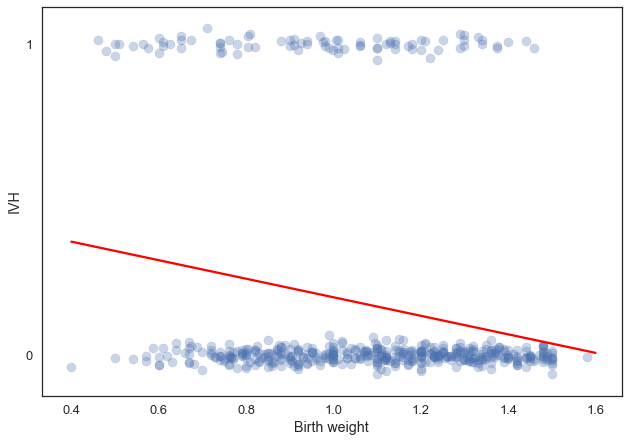

In [74]:
plt.scatter(bwt_kg, ivh + jitter, alpha=0.3)
plt.yticks([0,1])
plt.ylabel("IVH")
plt.xlabel("Birth weight")
plt.plot([0.4,1.6], [betas_vlbw[0] + betas_vlbw[1]*0.4, betas_vlbw[0] + betas_vlbw[1]*1.6], 'r-')

### Stochastic model

Rather than model the binary outcome explicitly, it makes sense instead to model the *probability* of death or survival in a **stochastic** model. Probabilities are measured on a continuous [0,1] scale, which may be more amenable for prediction using a regression line. We need to consider a different probability model for this exerciese however; let's consider the **Bernoulli** distribution as a generative model for our data:

<div style="font-size: 120%;">  
$$f(y|p) = p^{y} (1-p)^{1-y}$$ 
</div>  

where $y = \{0,1\}$ and $p \in [0,1]$. So, this model predicts whether $y$ is zero or one as a function of the probability $p$. Notice that when $y=1$, the $1-p$ term disappears, and when $y=0$, the $p$ term disappears.

So, the model we want to fit should look something like this:

<div style="font-size: 120%;">  
$$p_i = \beta_0 + \beta_1 x_i + \epsilon_i$$
</div>

However, since $p$ is constrained to be between zero and one, it is easy to see where a linear (or polynomial) model might predict values outside of this range. As with the Poisson regression, we can modify this model slightly by using a link function to transform the probability to have an unbounded range on a new scale. Specifically, we can use a **logit transformation** as our link function:

<div style="font-size: 120%;">  
$$\text{logit}(p) = \log\left[\frac{p}{1-p}\right] = x$$
</div>

Here's a plot of $p/(1-p)$

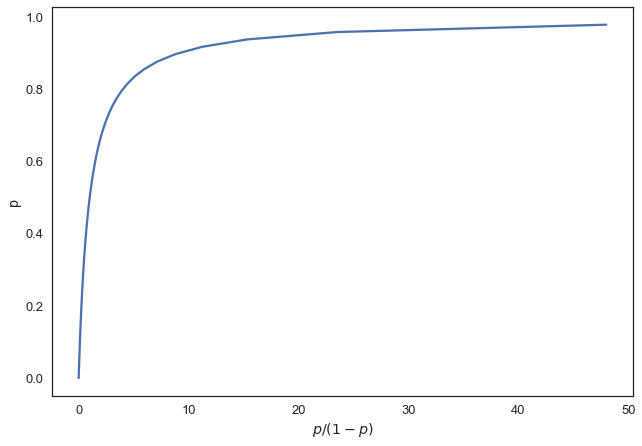

In [75]:
logit = lambda p: np.log(p/(1.-p))
unit_interval = np.linspace(0,1)
plt.plot(unit_interval/(1-unit_interval), unit_interval)
plt.xlabel(r'$p/(1-p)$')
plt.ylabel('p');

And here's the logit function:

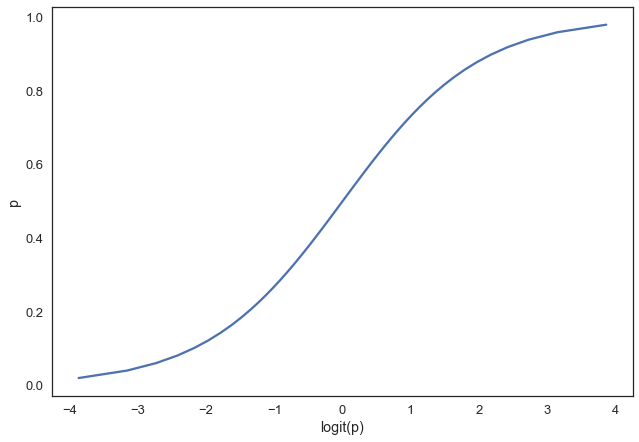

In [76]:
plt.plot(logit(unit_interval), unit_interval)
plt.xlabel('logit(p)')
plt.ylabel('p');

The inverse of the logit transformation is:

<div style="font-size: 150%;">  
$$p = \frac{1}{1 + \exp(-x)}$$
</div>

In [77]:
invlogit = lambda x: 1. / (1 + np.exp(-x))

So, now our model is:

<div style="font-size: 120%;">  
$$\text{logit}(p_i) = \beta_0 + \beta_1 x_i + \epsilon_i$$
</div>

We can fit this model using maximum likelihood. Our likelihood, again based on the Bernoulli model is:

<div style="font-size: 120%;">  
$$L(y|p) = \prod_{i=1}^n p_i^{y_i} (1-p_i)^{1-y_i}$$
</div>

which, on the log scale is:

<div style="font-size: 120%;">  
$$l(y|p) = \sum_{i=1}^n y_i \log(p_i) + (1-y_i)\log(1-p_i)$$
</div>

We can easily implement this in Python, keeping in mind that `fmin` minimizes, rather than maximizes functions:

In [78]:
def logistic_like(θ, x, y):
    
    p = invlogit(θ[0] + θ[1] * x)
    
    # Return negative of log-likelihood
    return -np.sum(y * np.log(p) + (1-y) * np.log(1 - p))

In [79]:
b0, b1 = fmin(logistic_like, [0.5,0], args=(bwt_kg, ivh))
b0, b1

Optimization terminated successfully.
         Current function value: 220.386526
         Iterations: 75
         Function evaluations: 142


(0.61576836431111337, -2.1722157373683615)

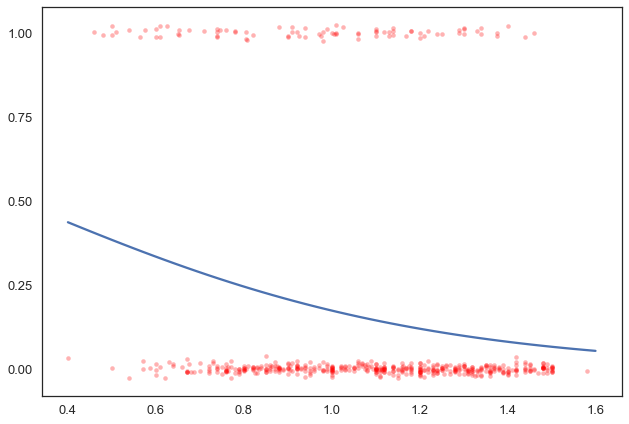

In [80]:
jitter = np.random.normal(scale=0.01, size=len(x))
plt.plot(x, ivh+jitter, 'r.', alpha=0.3)
plt.yticks([0,.25,.5,.75,1])
xvals = np.linspace(0.4, 1.6)
plt.plot(xvals, invlogit(b0+b1*xvals))

The logistic regression is just another type of GLM, this time with a Bernoulli distribution representing the sampling distribution of the data.

## Bayesian multivariate logistic regression

Let's once again drop our hand-fit model into a Bayesian context. This time we will model two variables, one discrete (pneumothorax) and one continuous (birth weight). First, we will center birth weight to aid interpretation:

In [81]:
bwt_centered = bwt_kg - bwt_kg.mean()

Our regression model for predicting the latent probability of IVH for each individual will be: 

$$p_i = \mu + \alpha * \text{bwt}_i + \beta * \text{pneumo}_i$$

here, $\mu$ is a baseline probability, $\alpha$ is a coefficient for centered birthweight, and $\beta$ is a coefficient for pneumothorax.

We then step through the procedure for coding a Bayesian model, first by specifing priors for the linear model coefficients:

In [84]:
with Model() as ivh_glm:
    
    μ = Normal('μ', 0, sd=10)
    α = Normal('α', 0, sd=10)
    β = Normal('β', 0, sd=10)

Then, apply the `invlogit` transformation to the linear combination of predictors:

In [85]:
from pymc3.math import invlogit

with ivh_glm:
        
    p = invlogit(μ + α*bwt_kg + β*pneumo)

Finally, the sampling distribution:

In [86]:
from pymc3 import Bernoulli

with ivh_glm:
            
    bb_like = Bernoulli('bb_like', p=p, observed=ivh)

In [89]:
with ivh_glm:
    
    trace_ivh = sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 224.35:  12%|█▏        | 24858/200000 [00:03<00:23, 7379.62it/s]
Convergence archived at 25000
Interrupted at 25,000 [12%]: Average Loss = 231.25
100%|██████████| 1500/1500 [00:03<00:00, 414.39it/s]


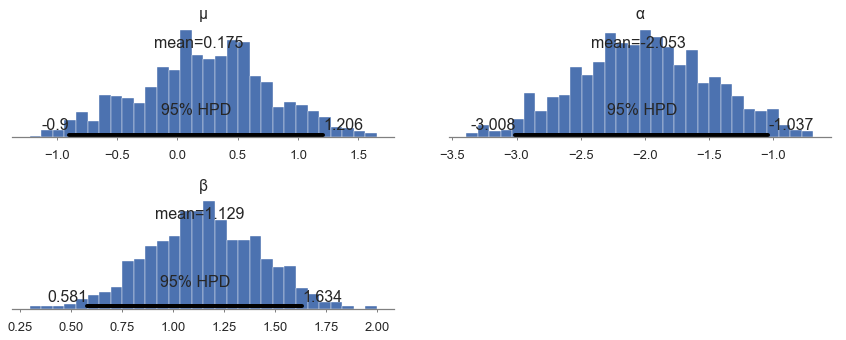

In [90]:
plot_posterior(trace_ivh);

## Interactions among variables

Interactions imply that the effect of one covariate $X_1$ on $Y$ depends on the value of another covariate $X_2$.

$$M(Y|X) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 +\beta_3 X_1 X_2$$

the effect of a unit increase in $X_1$:

$$M(Y|X_1+1, X_2) - M(Y|X_1, X_2)$$

$$\begin{align}
&= \beta_0 + \beta_1 (X_1 + 1) + \beta_2 X_2 +\beta_3 (X_1 + 1) X_2
- [\beta_0 + \beta_1 X_1 + \beta_2 X_2 +\beta_3 X_1 X_2] \\
&= \beta_1 + \beta_3 X_2
\end{align}$$

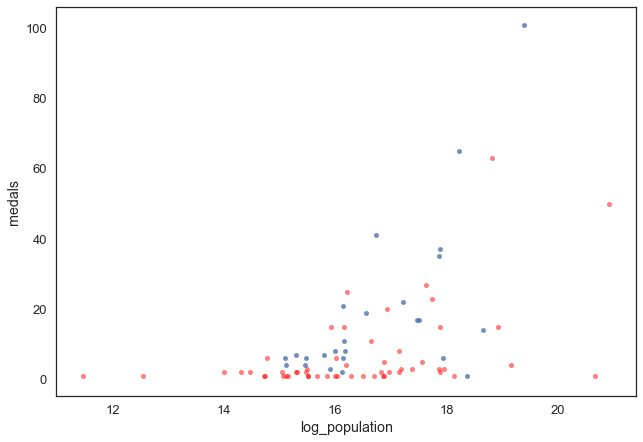

In [91]:
ax = medals[medals.oecd==1].plot(x='log_population', y='medals', kind='scatter', alpha=0.8)
medals[medals.oecd==0].plot(x='log_population', y='medals', kind='scatter', color='red', alpha=0.5, ax=ax)

Interaction can be interpreted as:

- $X_1$ interacts with $X_2$
- $X_1$ modifies the effect of $X_2$
- $X_2$ modifies the effect of $X_1$
- $X_1$ and $X_2$ are non-additive or synergistic

Let's construct a model that predicts medal count based on population size and OECD status, as well as the interaction. 

We can use the `dmatrix` function from the `patsy` library to set up a **design matrix**. This is a matrix of independent observations (rows) and predictors (columns) that defines the input to the model.

In [93]:
from patsy import dmatrix

y = medals.medals
X = dmatrix('log_population * oecd', data=medals)
X

DesignMatrix with shape (79, 4)
  Intercept  log_population  oecd  log_population:oecd
          1        11.47382     0              0.00000
          1        12.54819     0              0.00000
          1        14.76680     0              0.00000
          1        16.20904     0              0.00000
          1        16.72504     1             16.72504
          1        16.14509     1             16.14509
          1        15.91733     0              0.00000
          1        13.99525     0              0.00000
          1        15.10232     1             15.10232
          1        15.29285     1             15.29285
          1        16.15816     0              0.00000
          1        16.55847     1             16.55847
          1        14.31108     0              0.00000
          1        15.47603     1             15.47603
          1        15.10551     1             15.10551
          1        16.14891     1             16.14891
          1        14.46491     0

This matrix is multiplied by the vector of model coefficients to generate an estimate of the response corresponding to each row.

Now, fit the model.

In [97]:
interaction_params = fmin(poisson_loglike, [0,1,1,0], args=(X, y), maxiter=500)

Optimization terminated successfully.
         Current function value: -1492.092233
         Iterations: 491
         Function evaluations: 838


In [98]:
interaction_params

array([-5.29613802,  0.42443918, -2.16663151,  0.17974378])

Notice anything odd about these estimates?

The main effect of the OECD effect is negative, which seems counter-intuitive. This is because the variable is interpreted as the OECD effect when the **log-population is zero**. This is not particularly meaningful.

Asw we did with birth weight in the previous example, we can improve the interpretability of this parameter by centering the log-population variable prior to entering it into the model. This will result in the OECD main effect being interpreted as the marginal effect of being an OECD country for an **average-sized** country. 

In [99]:
y = medals.medals
X = dmatrix('center(log_population) * oecd', data=medals)
X

DesignMatrix with shape (79, 4)
  Intercept  center(log_population)  oecd  center(log_population):oecd
          1                -5.03303     0                     -0.00000
          1                -3.95866     0                     -0.00000
          1                -1.74005     0                     -0.00000
          1                -0.29781     0                     -0.00000
          1                 0.21819     1                      0.21819
          1                -0.36176     1                     -0.36176
          1                -0.58952     0                     -0.00000
          1                -2.51159     0                     -0.00000
          1                -1.40453     1                     -1.40453
          1                -1.21400     1                     -1.21400
          1                -0.34869     0                     -0.00000
          1                 0.05163     1                      0.05163
          1                -2.19577     0    

In [100]:
fmin(poisson_loglike, [0,1,1,0], args=(X, y))

Optimization terminated successfully.
         Current function value: -1492.092233
         Iterations: 303
         Function evaluations: 513


array([ 1.71003145,  0.42443035,  0.80033982,  0.17976563])

## Model Selection

How do we choose among competing models for a given dataset? More parameters are not necessarily better, from the standpoint of model fit. For example, fitting a 6th order polynomial to the LSD example certainly results in an overfit.

Optimization terminated successfully.
         Current function value: 304.786763
         Iterations: 830
         Function evaluations: 1284


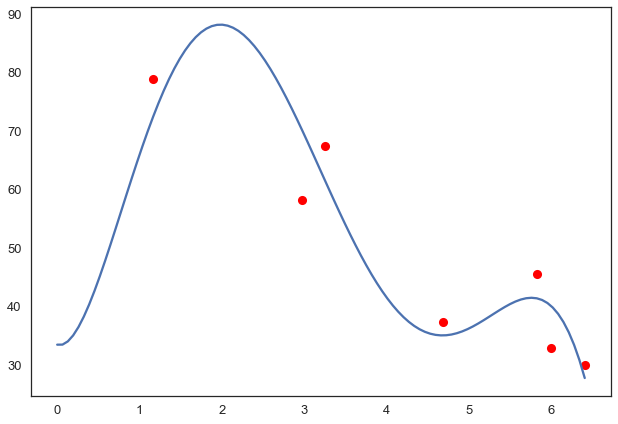

In [101]:
def calc_poly(params, data):
        x = np.c_[[data**i for i in range(len(params))]]
        return np.dot(params, x)

x, y = lsd_and_math.T.values
    
sum_squares_poly = lambda θ, x, y: np.sum((y - calc_poly(θ, x)) ** 2)
betas = fmin(sum_squares_poly, np.zeros(7), args=(x,y), maxiter=1e6)
plt.plot(x, y, 'ro')
xvals = np.linspace(0, max(x), 100)
plt.plot(xvals, calc_poly(betas, xvals))

One approach is to use an information-theoretic criterion to select the most appropriate model. For example **Akaike's Information Criterion (AIC)** balances the fit of the model (in terms of the likelihood) with the number of parameters required to achieve that fit. We can easily calculate AIC as:

$$AIC = n \log(\hat{\sigma}^2) + 2p$$

where $p$ is the number of parameters in the model and $\hat{\sigma}^2 = RSS/(n-p-1)$.

Notice that as the number of parameters increase, the residual sum of squares goes down, but the second term (a penalty) increases.

AIC is a metric of **information distance** between a given model and a notional "true" model. Since we don't know the true model, the AIC value itself is not meaningful in an absolute sense, but is useful as a relative measure of model quality.

To apply AIC to model selection, we choose the model that has the **lowest** AIC value.

In [102]:
n = len(x)

aic = lambda rss, p, n: n * np.log(rss/(n-p-1)) + 2*p

RSS1 = sum_of_squares(fmin(sum_of_squares, [0,1], args=(x,y)), x, y)
RSS2 = sum_squares_quad(fmin(sum_squares_quad, [1,1,-1], args=(x,y)), x, y)

print('\nModel 1: {0}\nModel 2: {1}'.format(aic(RSS1, 2, n), aic(RSS2, 3, n)))

Optimization terminated successfully.
         Current function value: 253.881329
         Iterations: 97
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: 251.093792
         Iterations: 177
         Function evaluations: 319

Model 1: 33.05400811127588
Model 2: 36.99049978705


Hence, on the basis of "information distance", we would select the 2-parameter (linear) model.

### Exercise: Olympic medals model selection

Use AIC to select the best model from the following set of Olympic medal prediction models:

- population only
- population and OECD
- interaction model

For these models, use the alternative form of AIC, which uses the log-likelhood rather than the residual sums-of-squares:

$$AIC = -2 \log(L) + 2p$$

In [45]:
# Write your answer here

## References

- Harrell, F. E. (2015). Regression Modeling Strategies (pp. 1–397).
- Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.